In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras.layers import Activation, Dense, Input, LSTM, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Sequential
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import mlflow

Using TensorFlow backend.


In [3]:
import datetime
import platform

from pathlib import Path
from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util as yass_util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import evaluate
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import TemplatesProcessor
from yass.geometry import make_channel_index

import numpy as np
from scipy.io import loadmat

from dstools import plot, reproducibility

# logging.basicConfig(level=logging.DEBUG)
savefig = False

In [4]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

mlflow.set_tracking_uri(str(Path(path_to_data, 'mlruns')))

In [5]:
import glob
import yaml

path_to_mlflow = '/home/Edu/data/mlruns'
meta = glob.glob(str(Path(path_to_mlflow, '**/meta.yaml')))

def load_yaml(path):
    with open(path) as f:
        content = yaml.load(f)
    return content

experiments = [load_yaml(p) for p in meta]

def get_id_for_experiment_with_name(name):
    matches = [e['experiment_id'] for e in experiments if e['name'] == name]
    if len(matches):
        return matches[0]
    else:
        return mlflow.create_experiment(name)

experiment_name = 'denoiser-rnn'
EXPERIMENT_ID = get_id_for_experiment_with_name(experiment_name)

In [6]:
print('Running YASS version: {}\nExperiment: {}'
      .format(yass_util.get_version(), experiment_name))

Running YASS version: 062a172 can create several copies of the same template in the same scale with the n_repeat parameter
Experiment: denoiser-rnn


In [7]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

## Load training set

In [8]:
from  mlflow.tracking import MlflowClient
client = MlflowClient()
experiments = client.list_experiments() 
experiment = client.get_experiment_by_name('denoiser-training-set')
training_set_runs = client.list_run_infos(experiment.experiment_id)

In [9]:
selected = [run for run in training_set_runs if run.run_uuid == 'fd205c908e3246fbbf071b4ba7e84328'][0]

In [10]:
path_to_training_set = Path(selected.artifact_uri, 'dataset.npz')

In [11]:
dataset = np.load(path_to_training_set)

In [12]:
x_train_noisy = dataset['x_train_noisy']
x_train_clean = dataset['x_train_clean']
x_test_noisy = dataset['x_test_noisy']
x_test_clean = dataset['x_test_clean']

In [13]:
selected = np.random.randint(x_test_noisy.shape[0], size=10)

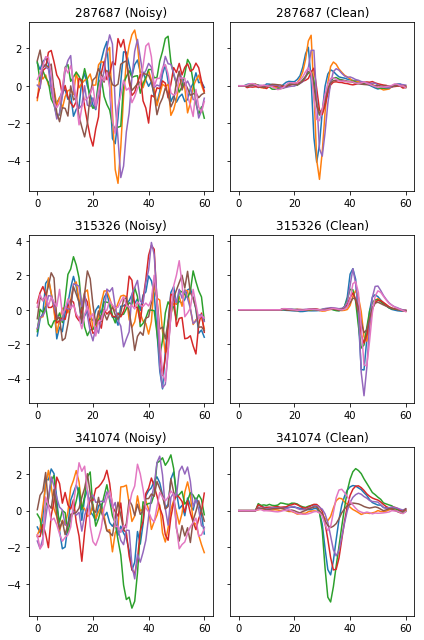

In [14]:
plot.grid_from_array([x_test_noisy,
                      x_test_clean],
                     axis=0,
                     group_names=('Noisy', 'Clean'),
                     elements=selected[:3],
                     auto_figsize=3,
                     sharey='row')

In [15]:
ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)

In [16]:
channel = 0
neighbors = ch_idx[channel]

In [17]:
_, wf_length, _ = x_train_noisy.shape

In [18]:
middle = int((wf_length - 1)/2)

In [19]:
# INPUT FOR THE DENOISER
half_window_size = 10

window = slice(middle-half_window_size, middle+half_window_size+1)

x_train = x_train_noisy[:, window, neighbors]
x_test = x_test_noisy[:, window, neighbors]

y_train = x_train_clean[:, middle, channel]
y_test = x_test_clean[:, middle, channel]

In [20]:
x_train.shape, y_train.shape

((816480, 21, 7), (816480,))

In [22]:
from keras.layers import MaxPooling2D

n_spikes, waveform_length, n_neighbors = x_train.shape

# Network parameters
input_shape = (waveform_length, n_neighbors, 1)
batch_size = 800
kernel_size = (5, 7)

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [16, 32, 64, 128, 256]
n_layers = len(layer_filters)

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)
    x = MaxPooling2D(2, padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

x = Flatten()(x)

x = Dense(64, activation='relu')(x)

y = Dense(1, activation='linear')(x)

denoiser = Model(inputs, y, name='denoiser')
denoiser.summary()

denoiser.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 21, 7, 1)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 7, 16)         576       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 4, 16)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 4, 32)         17952     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 2, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 2, 64)          71744     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 1, 64)          0         
__________

In [25]:
# Training parameters
epochs = 1
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)]

history = denoiser.fit(x_train[:, :, :, np.newaxis],
                       y_train,
                       validation_data=(x_test[:, :, :, np.newaxis],
                                        y_test),
                       epochs=epochs,
                       callbacks=callbacks,
                       batch_size=batch_size)

Train on 816480 samples, validate on 349920 samples
Epoch 1/1
816480/816480 [==============================] - 43s 53us/step - loss: 0.0503 - val_loss: 0.0645


val: 0.0653

In [26]:
denoiser.save('/home/Edu/data/denoiser/models/latest.h5')
denoiser.save('/tmp/denoiser.h5')

## Denoising patches

## Denoising simulated recordings

## Denoising recordings

In [105]:
exp = RecordingExplorer(path_to_standarized)

In [107]:
patch_size = waveform_length
n_patches = 1000
offset = 150000

In [108]:
idxs = [(n, n + patch_size) for n in range(n_patches)]

In [109]:
patches = np.empty((n_patches, patch_size, 7, 1))

for i, (from_, to_) in enumerate(idxs):
    patches[i, :, :, 0] = exp.reader[from_:to_, neighbors]

In [110]:
patches_denoised = np.squeeze(denoiser.predict(patches))

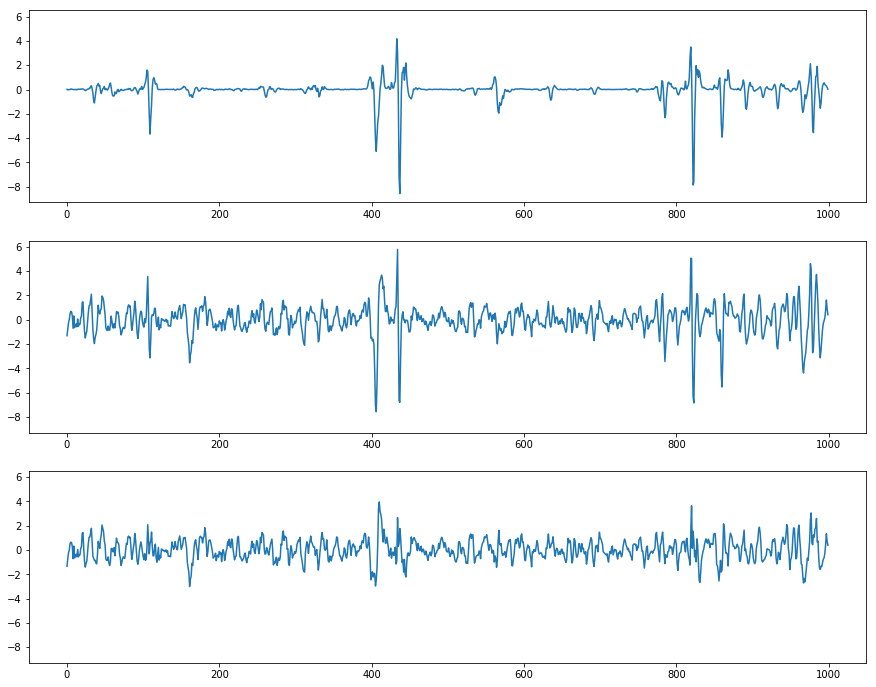

In [112]:
plt.rcParams['figure.figsize'] = (15, 12)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

_ = ax1.plot(patches_denoised)

start = idxs[0][0] + half_window_size
end = idxs[-1][1] - half_window_size

raw = exp.reader[start:end, channel]
_ = ax2.plot(raw)

_ = ax3.plot(raw - patches_denoised)